# [ARC] Simple Object Searcher

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import os, shutil
import json
from pathlib import Path
import sys
from datetime import datetime

import torch.nn.functional as F
from fastai.vision import *
from fastai.utils.mod_display import *
from torchvision import utils

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import stats
from sklearn import metrics

from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.utils.mod_display import *

from PIL import Image

In [2]:
kaggle_input_path = '/kaggle/input'

kaggle_arc_path = '/arc/input'


np.set_printoptions(threshold=sys.maxsize)

#for dirname, _, filenames in os.walk(kaggle_input_path):
#    print(dirname)

In [3]:
from pathlib import Path

data_path = Path(kaggle_input_path+'/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

In [4]:
def task_sample_arr(taskname, test_train = 'train', in_out = 'input', idx = 0, path=training_path):
    task_file = str(path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    return np.array(task[test_train][idx][in_out])


def load_task(taskname, path=training_path):
    task_file = str(path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    return task


## Function to plot task
Modified version of plot_task from https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook.



In [5]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25' ,'#FFFFFF'])

cnorm = colors.Normalize(vmin=0, vmax=10) #vmax=9

def plot_task(taskname, path = training_path, pred_imgs=[], max_train = -1):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    
    # loading tasks
    task_file = str(path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    if len(pred_imgs) == 0:
        rows = 2
    else:
        rows = 4
    
    if max_train == -1:
        # show all
        max_train = len(task['train'])  
    
    fig, axs = plt.subplots(rows, (max_train+len(task['test']))*2, figsize=(15,2*rows))
    offset = 0
    for i in range(max_train):
        axs[0, i*2].imshow(task['train'][i]['input'], cmap=cmap, norm=cnorm)
        axs[0, i*2].axis('off')
        axs[0, i*2].set_title('Train In '+str(i))
        
        axs[0, i*2+1].imshow(task['train'][i]['output'], cmap=cmap, norm=cnorm)
        axs[0, i*2+1].axis('off')
        axs[0, i*2+1].set_title('Train Out '+str(i))
        
        offset+=2
        
    for i in range(len(task['test'])):
        j=i*2+offset
        axs[0, j].imshow(task['test'][i]['input'], cmap=cmap, norm=cnorm)
        axs[0, j].set_title('Valid In '+str(i))
        axs[0, j].axis('off')
        
        axs[0, j+1].imshow(task['test'][i]['output'], cmap=cmap, norm=cnorm)
        axs[0, j+1].set_title('Valid Out '+str(i))
        axs[0, j+1].axis('off')
            
    if rows == 4:
        for p, pred_img in enumerate(pred_imgs):
            y = -2*(len(pred_imgs))+2*p+1
            axs[1, y].imshow(pred_img, cmap=cmap, norm=cnorm)
            axs[1, y].set_title('Pred img')
            #for i in range(len(task['test'])+max_train*2):
            #    axs[2, i ].axis('off')

            rs_pred_img = pred_img.astype('int8')
            #     resize_unpad(pred_img,task_info[taskname]['max_xy'],
            #                           np.round(task_info[taskname]['test_in_shapes'][p] * 
            #                                    task_info[taskname]['avg_train_shape_factor'])
            #                          )
            #acc = metrics.accuracy_score(np.array(task['test'][p]['output']).reshape(1,-1)[0], rs_pred_img.reshape(1,-1)[0])
        
            axs[2, y].imshow(rs_pred_img, cmap=cmap, norm=cnorm)
            axs[2, y].set_title(f'Pred img croped and rescaled (acc: {acc:.4f})')
        
        for i in range((len(task['test'])+max_train)*2):
            axs[1, i].axis('off')
            axs[2, i].axis('off')
                
        #acc = metrics.accuracy_score(np.array(task['test'][0]['output']).reshape(1,-1)[0], rs_pred_img.reshape(1,-1)[0])
        #print(f"Accuracy: {acc}")
                
    plt.tight_layout()
    #plt.savefig(f'{kaggle_arc_path}/temp/output/eval_{taskname}.png', dpi=None, facecolor='w', edgecolor='w',orientation='landscape')
    plt.show()

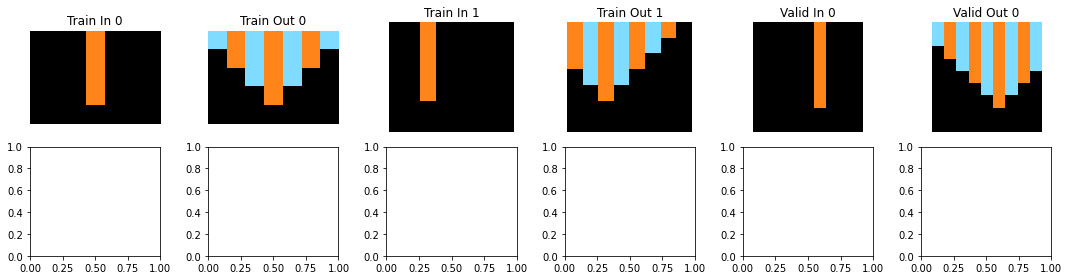

In [6]:
taskname = 'db3e9e38' #'ae58858e'
plot_task(taskname, path = training_path) #training_path #evaluation_path)#, max_train=2)

plt.show() 

## Kernels

In [7]:
def k_gen(kernel, ignore_dir = True):
    """
    Generic kernel function. Adds distortion if ignore_dir = False, which causes the direction of the object being relevant:
    
        ignore_dir == True:
            
            xxxx               xxx
             xxx   is equals   xxxx
        
        ignore_dir == False:
        
            xxxx                   xxx
             xxx   is not equals   xxxx
    
    Adding distortion might make the "Hash" be a bit more robust regarding uniqueness for some symetric objects (see issue with k_uni).
    """
    
    if ignore_dir:
        distortion = torch.Tensor([[1, 1, 1],[1, 1, 1],[1, 1, 1]]);
    else:
        distortion = torch.Tensor([[1.01, 1.02, 1.03],[1.04, 1.05, 1.06],[1.07, 1.08, 1.09]]);
    
    return (kernel*distortion).view((1,1,3,3,1))
    

def k_uni(ignore_dir = True):
    """
    Direction does not matter, e.g. 
    
        xxxx               xxx
         xxx   is equals   xxxx
         
    "Hash" might not be unique for some symetric objects, e.g.

          x                      x
         x    considered equals   x
        xx                       xx
    
    """
    kernel = torch.Tensor([[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]])
    
    return k_gen(kernel, ignore_dir)


def k_plus(ignore_dir = True):
    """
    Same as k_uni, but doesn't consider diagonals as connection, e.g.
    
          xx
          xx     k_uni: 1 object
        xx       k_plus: 2 objects
        xx     
        
    """
    kernel = torch.Tensor([[0, 1, 0],
                           [1, 1, 1],
                           [0, 1, 0]])
    
    return k_gen(kernel, ignore_dir)


def k_x(ignore_dir = True):
    """
    Same as k_uni, but only considers diagonals as connection, e.g.
    
          xx
          xx     k_uni: 1 object
        xx       k_plus: 2 objects
        xx       k_x: 3 objects
        
    """
    kernel = torch.Tensor([[1, 0, 1],
                           [0, 1, 0],
                           [1, 0, 1]])
    
    return k_gen(kernel, ignore_dir)


In [8]:
torch.Tensor([[1, 1, 1],[1, 1, 1],[1, 1, 1]]) * torch.Tensor([[1, 1, 1],[1, 1, 1],[1, 1, 1]]) 

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [9]:
class ObjectDetail:
    
    
    def __init__(self, colors, locs, shadow_locs, freq_per_color, freq_total, parent_objects, obj_classes):
        self.colors = colors
        self.locs = locs
        self.shadow_locs = shadow_locs
        self.freq_per_color = freq_per_color
        self.freq_total = freq_total
        self.parent_objects = parent_objects
        self.obj_classes = obj_classes


        
class ClassDetail:
    
    
    def __init__(self, colors, locs, shadow_locs, freq_per_color, freq_total, parent_objects, obj_classes):
        self.colors = colors
        self.locs = locs
        self.shadow_locs = shadow_locs
        self.freq_per_color = freq_per_color
        self.freq_total = freq_total
        self.parent_objects = parent_objects
        self.obj_classes = obj_classes


        
class ObjectIndex:
    
    
    SHADOW_CHANNEL = 10
    
    
    def __init__(self, img, kernel=k_uni(), neighbours = 10, bg = None):
    
        self.img = img
        
        self.bg = bg
        
        self.kernel = kernel
        
        # convert to 11 channel (1 for each color + one for all non background colors) and apply one hot encoding
        self.ohe = self.__ohe_ch(img, 11).unsqueeze(0).float()

        # get non background color channels
        self.non_bg_channels = list(set([i for i in range(10)])-set([bg]))

        # add "shadow" channel including all ohe of non bg channels. 
        # This becomes the object-identifying channel while the other channels can be used 
        # to identify (color dependent) parts of an objects, e.g.
        #
        #            ##OX                         ##      O        X
        #    Object   ##X  consists of the part  ##  and     and   X
        #
        self.ohe[:,:,:,:,self.SHADOW_CHANNEL] = self.ohe[:,:,:,:,self.non_bg_channels].sum(axis=4)

        # normalization parameter
        ndiv=kernel.sum()

        obj_map = self.ohe
        for i in range(neighbours):
            # calculate "hash"-like values for the objects
            obj_map = (F.conv3d(obj_map, kernel, padding=[1,1,0]) * self.ohe).div(ndiv) * (i+1)
        obj_map = (obj_map*10000).round() # round to avoid fload precision issue while using as hash
        
        freq = {'freq_obj_col_'+str(i): Counter(obj_map[:,:,:,:,i].flatten().numpy()) for i in self.non_bg_channels}
        freq['freq_obj_shadow']= Counter(obj_map[:,:,:,:,self.SHADOW_CHANNEL].flatten().numpy())
        freq['freq_obj_all_col'] = Counter(obj_map[:,:,:,:, self.non_bg_channels].flatten().numpy())
        # remove zeros (no object)
        for c in freq:
            del freq[c][0]

        self.freq = freq
        self.obj_map = obj_map
       
        ## cluster shadow objects to parent objects
        self.obj_cluster, self.obj_class, self.class_count = self.__cluster_parent_objects(self.obj_map[:,:,:,:,-1].view(self.img.shape[0], 
                                                                                                       self.img.shape[1]), 
                                                                         self.kernel.view(3,3))
        
        # get some details per object
        self.object_details = {} 
        for obj_id in torch.unique(obj_map):
            colors = self.find_colors(obj_id)
            locs = self.find_locs(obj_id)
            shadow_locs = self.find_locs(obj_id, shadow_locs = True)
            freq_per_color = self.find_color_freq(obj_id)
            freq_total = locs.shape[0]
            parent_objects = self.find_objects(locs, self.SHADOW_CHANNEL)
            if isinstance(self.obj_class, pd.DataFrame):
                obj_classes = self.obj_class['class_id'].unique()
            else:
                obj_classes = None
            self.object_details[obj_id.item()] = ObjectDetail(colors, locs, shadow_locs, freq_per_color, freq_total, parent_objects, obj_classes)
        
        
    def find_locs(self, obj_id, shadow_locs = False, locs_only = True):
    
        if shadow_locs:
            search_channels = self.SHADOW_CHANNEL
        else: 
            search_channels = self.non_bg_channels
            
        return self.__find_by_id(obj_id, search_channels, locs_only)
    
    
    def find_colors(self, obj_id):
        
        return (self.obj_map[:,:,:,:,:-1] == obj_id).nonzero()[:,-1].unique().tolist()
        
   
    def find_color_freq(self, obj_id):
        
        return Counter((self.obj_map[:,:,:,:,:-1] == obj_id).nonzero()[:,-1].flatten().numpy())
        
    
    def find_objects(self, locs, search_channels):
        
        o = Tensor()
        
        for i, l in enumerate(locs):
            o = torch.cat((o,self.obj_map[:,:,:,:,search_channels][:,:,l[0],l[1]]),-1)
        
        return o.unique()[o.unique()!=0.] # remove 0 from list
    
    
    def __find_by_id(self, obj_id, search_channels, locs_only):
        
        locs = (self.obj_map[:,:,:,:,search_channels] == obj_id).nonzero()
        
        if locs_only:
            locs = locs[:,2:4]
        
        return locs
    
        
    def __ohe_ch(self, x, channels = 10):
        """ Converts an np.array to n one hot encoded channels"""
        x_shape = x.shape
        x =  Tensor(x).flatten().long()
        return torch.nn.functional.one_hot(x,channels).view(x_shape[0],x_shape[1],channels).unsqueeze(0)
 
    
    def __cluster_parent_objects(self, t, k):
        z = torch.zeros(t.shape[0], t.shape[1])
        z_class = None
        class_attr = None
        d_loc = {}
        d_parent_id = {}
        
        max_parent_id = 0
        for i in t.nonzero():
            parent_id = None
            i_key = str(i[0].item())+'_'+ str(i[1].item()) # "/1" => to float
            for offset in k.nonzero()+Tensor([-1,-1]):
                lu_loc = (i + offset).to(torch.int)
                genkey = str(int(lu_loc[0].item()))+'_'+ str(int(lu_loc[1].item()))

                # 1st it
                if parent_id == None:
                    parent = d_parent_id.get(genkey)

                    if parent == None:
                        max_parent_id += 1
                        parent_id = max_parent_id
                    else:
                        parent_id = parent.get('id')

                    z[i[0].item(), i[1].item()] = parent_id
                    d_parent_id[i_key] = {'id': parent_id, 'child_val': t[i[0].item(), i[1].item()]}
                    cur_locs = d_loc.get(parent_id)
                    if cur_locs == None:
                        d_loc[parent_id] = {'locs': [i_key], 'class_id': t[i[0].item(), i[1].item()]}
                    else:
                        d_loc[parent_id] = {'locs': cur_locs['locs'] + [i_key], 'class_id': cur_locs['class_id'] + t[i[0].item(), i[1].item()]}


                # other it
                elif genkey!=i_key:
                    # lookup if loc has already been registered
                    cur_parent = d_parent_id.get(genkey)
                    if cur_parent != None:
                        cur_parent_id = cur_parent.get('id')
                        # merge parent_ids
                        cur_locs = d_loc.get(cur_parent_id)
                        for cl in cur_locs['locs']: # list of locs
                            # set new parent_id
                            d_parent_id[cl] = {'id': parent_id, 'child_val': t[i[0].item(), i[1].item()]}
                            z[int(cl.split('_')[0]), int(cl.split('_')[1])] = parent_id

                        if cur_parent_id != parent_id:
                            temp_d_loc_entry = {'locs': d_loc.get(parent_id)['locs'] + cur_locs['locs'], 'class_id': d_loc.get(parent_id)['class_id'] + cur_locs['class_id'] }
                            d_loc[parent_id] = temp_d_loc_entry
                            del d_loc[cur_parent_id]
                             #del d_val[cur_parent_id]
        
        for d in d_loc:
            
            class_id = d_loc.get(d)['class_id'].item()
            class_elem_cnt = len(d_loc.get(d)['locs'])
            
            #count classes and class element
            if not isinstance(class_attr, pd.DataFrame):
                class_attr = pd.DataFrame({'class_id': [class_id], 
                            'class_elem_cnt': [class_elem_cnt]})
            else:
                class_attr = class_attr.append({'class_id': class_id, 
                            'class_elem_cnt': class_elem_cnt}, ignore_index=True)
            
            #locs
            for l in d_loc.get(d)['locs']:
                #z_class[int(l.split('_')[0]), int(l.split('_')[1])] = class_id
                if not isinstance(z_class, pd.DataFrame):
                    z_class = pd.DataFrame({'class_id': [class_id], 
                                'x':[int(l.split('_')[1])], 
                                'y':[int(l.split('_')[0])],
                                'color': [self.img[int(l.split('_')[0]), int(l.split('_')[1])]],
                                'class_elem_cnt': class_elem_cnt})
                else:
                    z_class = z_class.append({'class_id': class_id, 
                                'x':int(l.split('_')[1]), 
                                'y':int(l.split('_')[0]),
                                'color': self.img[int(l.split('_')[0]), int(l.split('_')[1])],
                                'class_elem_cnt': class_elem_cnt}, ignore_index=True)
        
        
        if isinstance(class_attr, pd.DataFrame):
            class_attr = class_attr.drop_duplicates()
            class_attr['class_count'] = class_attr.groupby(['class_id'])['class_id'].transform('count')
            class_attr['class_elem_cnt_rank'] = class_attr['class_elem_cnt'].rank(method = 'dense').drop_duplicates().reset_index(drop= True)
        
        if isinstance(z_class, pd.DataFrame):
            z_class['class_elem_cnt_rank'] = z_class['class_elem_cnt'].rank(method = 'dense')
        
        return z, z_class, class_attr

        
### Test

img = task_sample_arr('db3e9e38', test_train = 'train', in_out = 'input', idx = 0, path = training_path) #e8593010
oi = ObjectIndex(img, kernel = k_plus(), bg = 0)

#img, oi.freq, oi.obj_map[:,:,:,:,6], oi.find_locs(21332932, False), oi.find_locs(21332932), oi.find_colors(21332932), oi.object_details[21332932].colors, 

oi.obj_class, oi.obj_cluster, oi.class_count

(      class_id    x    y  color  class_elem_cnt  class_elem_cnt_rank
 0  212972576.0  3.0  0.0    7.0             4.0                  1.0
 1  212972576.0  3.0  1.0    7.0             4.0                  1.0
 2  212972576.0  3.0  2.0    7.0             4.0                  1.0
 3  212972576.0  3.0  3.0    7.0             4.0                  1.0,
 tensor([[0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]),
       class_id  class_elem_cnt  class_count  class_elem_cnt_rank
 0  212972576.0               4            1                  1.0)

In [10]:
img = task_sample_arr('321b1fc6', test_train = 'train', in_out = 'input', idx = 0)
oii0 = ObjectIndex(img, kernel = k_plus(), bg = 0)
print(oii0.freq['freq_obj_all_col'], oii0.freq['freq_obj_shadow'])

img = task_sample_arr('321b1fc6', test_train = 'train', in_out = 'output', idx = 0)
oio0 = ObjectIndex(img, kernel = k_plus(), bg = 0)
print(oio0.freq['freq_obj_all_col'], oio0.freq['freq_obj_shadow'])

img = task_sample_arr('321b1fc6', test_train = 'train', in_out = 'input', idx = 1)
oii1 = ObjectIndex(img, kernel = k_plus(), bg = 0)
print(oii1.freq['freq_obj_all_col'], oii1.freq['freq_obj_shadow'])

img = task_sample_arr('321b1fc6', test_train = 'train', in_out = 'output', idx = 1)
oio1 = ObjectIndex(img, kernel = k_plus(), bg = 0)
print(oio1.freq['freq_obj_all_col'], oio1.freq['freq_obj_shadow'])


Counter({219419620.0: 12, 3716.0: 4}) Counter({219419620.0: 16})
Counter({3716.0: 12}) Counter({219419620.0: 12})
Counter({346499420.0: 6, 324430750.0: 3, 415637300.0: 3, 194653250.0: 3, 3805073.0: 2, 21332932.0: 2, 30169322.0: 1}) Counter({346499420.0: 8, 324430750.0: 4, 415637300.0: 4, 194653250.0: 4})
Counter({3805073.0: 6, 21332932.0: 6, 30169322.0: 3}) Counter({346499420.0: 6, 324430750.0: 3, 415637300.0: 3, 194653250.0: 3})


In [11]:
def reduce_color_map(color_map, key = 'class_id'):
    # make sure mapping is unique
    color_map.drop_duplicates(inplace = True)
    color_map['cnt_by_from'] = color_map.groupby([key, 'color_from'])[key].transform('count')
    return color_map[color_map.cnt_by_from == 1][[key, 'color_from', 'color_to']]


def bg(img):

    all_colors = [i for lst in img for i in lst.reshape(1,-1).tolist()]
    bgcolor = stats.mode(all_colors,axis=None)[0]

    return bgcolor[0]


def common_bgcolor(img1, img2):
    """
    None if different background color.
    """

    bgcolor = None

    bg1 = bg(img1)
    bg2 = bg(img2)

    if bg1 == bg2:
        bgcolor = bg1

    return bgcolor




class IdxComperator():
    
    SHADOW_CHANNEL = 10
    
    def __init__(self, object_index_1, object_index_2):
        
        self.object_index_1 = object_index_1
        self.object_index_2 = object_index_2
        
    
    ########################
    ### Image in general ###
    ########################
    
    
    def scale_factor(self):
        
        return (self.object_index_1.img.shape[0] / self.object_index_2.img.shape[0], 
                self.object_index_1.img.shape[1] / self.object_index_2.img.shape[1])
        
    
    ########################
    ###  Shadow related  ###
    ########################

    
    def same_shadow(self):
        
        return (self.object_index_1.obj_map[:,:,:,:, self.SHADOW_CHANNEL] == self.object_index_2.obj_map[:,:,:,:, self.SHADOW_CHANNEL]).min().item()
    
    
    ########################
    ###  Object related  ###
    ########################

    
    def diff_num_obj_per_channel(self):
    
        n = []
        for cf in self.object_index_1.freq:
            n.append(sum(self.object_index_1.freq[cf].values()) - sum(self.object_index_2.freq[cf].values()))
    
        return n
    
    
    def removed_objects(self):
        
        objs1 = self.object_index_1.object_details.keys()
        objs2 = self.object_index_2.object_details.keys()
        
        return list(set(objs1) - set(objs2))
    
    
    def added_objects(self):
    
        objs1 = self.object_index_1.object_details.keys()
        objs2 = self.object_index_2.object_details.keys()
        
        return list(set(objs2) - set(objs1))
    
    
    # map for obj when color changed
    def color_map(self):
        
        color_map = {}
        
        ods1 = self.object_index_1.object_details
        ods2 = self.object_index_2.object_details
        
        for o in ods1:
            details1 = ods1.get(o)
            if details1 == None:
                    continue
            colors1 = details1.colors
            details2 = ods2.get(o)
            if details2 == None:
                    continue
            colors2 = details2.colors

            if list(colors1) != list(colors2) and list(colors2) != []:
                color_map[o] = {'from': colors1, 'to': colors2}
                
        return color_map
    
    
    # map for classes when color changed
    def class_color_map(self, key = 'class_id'):
        
        color_map = None
        
        if isinstance(self.object_index_1.obj_class, pd.DataFrame) and isinstance(self.object_index_2.obj_class, pd.DataFrame):
            oc1 = self.object_index_1.obj_class[[key, 'color']].drop_duplicates()
            oc2 = self.object_index_2.obj_class[[key, 'color']].drop_duplicates()
            
            color_map = oc1.merge(oc2.set_index(key), 'inner', on = [key], suffixes = ('_from', '_to')).drop_duplicates().reset_index(drop = True)
            if isinstance(color_map, pd.DataFrame):
                color_map = reduce_color_map(color_map, key = key) 
        
        return color_map
    
    
    # map for classes when they have same number of elements rank and color changed
    def class_elem_cnt_rank_color_map(self):
        
        return self.class_color_map(key = 'class_elem_cnt_rank')
        
    
    # map for classes when they have same number of elements and color changed
    def class_elem_cnt_color_map(self):
        
       # color_map = None
       # 
       # if isinstance(self.object_index_1.obj_class, pd.DataFrame) and isinstance(self.object_index_2.obj_class, pd.DataFrame):
       #     oc1 = self.object_index_1.obj_class[['class_id', 'color']].merge(
       #                 self.object_index_1.class_count[['class_id', 'class_elem_cnt']].set_index('class_id'),
       #                 'inner', on = ['class_id']).drop_duplicates().reset_index(drop = True)[['class_elem_cnt', 'color']]
       #     oc2 = self.object_index_2.obj_class[['class_id', 'color']].merge(
       #                 self.object_index_2.class_count[['class_id', 'class_elem_cnt']].set_index('class_id'),
       #                 'inner', on = ['class_id']).drop_duplicates().reset_index(drop = True)[['class_elem_cnt', 'color']]
       #     
       #     color_map = oc1.merge(oc2.set_index('class_elem_cnt'), 'left', on = ['class_elem_cnt'], suffixes = ('_from', '_to')).drop_duplicates().reset_index(drop = True)
       #     color_map = reduce_color_map(color_map, key = 'class_elem_cnt') 
        
        return self.class_color_map(key = 'class_elem_cnt')
    
    
    # check if whole color channel has switched  
    def palette_map(self):
        
        palette_map = {} # from: to
        
        om1 = self.object_index_1.ohe
        om2 = self.object_index_2.ohe
        
        for i in range(10):
            for j in range(10):
                if (om1[:,:,:,:,i] - om2[:,:,:,:,j]).max() < 1 and (om1[:,:,:,:,i]).max() == 1: #i != j and 
                    palette_map[i] = j
    
        return palette_map
    
    
    def color_in_use(self):
        
        c = []
        
        om1 = self.object_index_1.ohe
        
        for i in range(10):
            if (om1[:,:,:,:,i]).max() == 1:
                c = c + [i]
        
        return c
    
    
    # map for obj when coordinates changed
    def location_map(self):
        
        loc_map = {}
        
        ods1 = self.object_index_1.object_details
        ods2 = self.object_index_2.object_details
        for o in ods1:
            details1 = ods1.get(o)
            if details1 == None:
                    continue
            locs1 = details1.locs.tolist()
            details2 = ods2.get(o)
            if details2 == None:
                    continue
            locs2 = details2.locs.tolist()

            if locs1 != locs2 and locs2 != []:
                loc_map[o] = {'from': locs1, 'to': locs2}
                
        return loc_map
    
    
    # map old to new object depending of coordinates
    def object_map(self, same_color, ignore_bg = False):
        
        if ignore_bg:
            ch1 = self.object_index_1.non_bg_channels
            ch2 = self.object_index_2.non_bg_channels
        else:
            ch1 = list(range(10))
            ch2 = list(range(10))
        
        bg1 = self.object_index_1.bg
        bg2 = self.object_index_2.bg
        
        oi1 = self.object_index_1.obj_map[:,:,:,:,ch1]
        oi1s = oi1.view(oi1.shape[2:]).sum(axis=-1)
        oi2 = self.object_index_2.obj_map[:,:,:,:,ch2]
        oi2s = oi2.view(oi2.shape[2:]).sum(axis=-1)
        
        diff_mask = oi1s != oi2s
        
        o_old = oi1s[diff_mask]
        o_new = oi2s[diff_mask]
        c_old = self.object_index_1.img[diff_mask]
        c_new = self.object_index_2.img[diff_mask]
        loc = diff_mask.nonzero()
        
        return [{'obj_old': old.item(), 
                 'obj_new': o_new[i].item(), 
                 'color_old': c_old[i], 
                 'color_new': c_new[i],
                 'loc': loc[i],
                 'cluster': self.object_index_1.obj_cluster[loc[i][0],loc[i][1]].item()} 
                for i, old in enumerate(o_old) if ((same_color and c_old[i] == c_new[i]) or 
                                                    (not same_color and c_old[i] != c_new[i])) and
                                                    (not ignore_bg or 
                                                    (ignore_bg and c_old[i] != bg1 and c_new[i] != bg2))]

    
    def removed_classes(self):
        ncl1 = self.object_index_1.class_count
        ncl2 = self.object_index_2.class_count
        
       
        ncl = ncl1.merge(ncl2, 'left', on='class_id')
        ncl['removed_classes'] = ncl.class_count_x - ncl.class_count_y
        ncl = ncl[ncl.removed_classes > 0].drop(['class_count_x', 'class_count_y'],axis=1)
        
        return ncl
    
    
    def added_classes(self):
        ncl1 = self.object_index_1.class_count
        ncl2 = self.object_index_2.class_count
        
        ncl = ncl2.merge(ncl1, 'left', on='class_id')
        ncl['added_classes'] = ncl.class_count_x - ncl.class_count_y
        ncl = ncl[ncl.added_classes > 0].drop(['class_count_x', 'class_count_y'],axis=1)
        
        return ncl
    
    
   # def color_of_cluster_changed(self):
            
    
    def interpreter(self):
    
        msg = []
    
        if self.scale_factor() != (1,1):
            msg.append('different image size => split image and compare parts separetly')
        else:
            msg.append('same image size')
            
            if self.same_shadow() and min(self.diff_num_obj_per_channel()) == 0:
                msg.append('same shadow, same objects => some objects changed color')

            if self.same_shadow() and min(self.diff_num_obj_per_channel()) != 0:
                msg.append('same shadow, different objects => '+
                           'some objects changed, but kept shadow (e.g. framing, filling, 50cb2852).')
        
        msg.append(f'removed objects: {len(self.removed_objects())}.')
        
        msg.append(f'added objects: {len(self.added_objects())}.')
        
        if len(self.removed_objects()) != len(self.added_objects()):
            msg.append(f'diff between removed objects and added objects happens if removed objects stay part of the shadow, hence only color changed.')
        
        if len(self.color_map()) > 0:
            msg.append(f'some colors changed: {len(self.color_map())}.')
        
        if len(self.class_color_map()) > 0:
            msg.append(f'some class_colors changed: {len(self.class_color_map())}.')
        
        if len(self.class_elem_cnt_color_map()) > 0:
            msg.append(f'some class_elem_cnt changed: {len(self.class_elem_cnt_color_map())}.')
        
        if len(self.class_elem_cnt_rank_color_map()) > 0:
            msg.append(f'some class_elem_cnt changed: {len(self.class_elem_cnt_rank_color_map())}.')
        
        if self.scale_factor() == (1,1) and len(self.palette_map()) > 0:
            msg.append(f'{len(self.palette_map())} palettes changed.')
        
        if len(self.color_in_use()) > 0:
            msg.append(f'{len(self.color_in_use())} colors in use by image 1.')
        
        if len(self.location_map()) > 0:
            msg.append(f'some object coordinates changed: {len(self.location_map())}.')
            
        if self.scale_factor() == (1,1):
        
            if len(self.object_map(same_color = True, ignore_bg = False)) > 0:
                msg.append(f'objects changed but not the color (by loc, incl. backgroud): {len(self.object_map(same_color = True))}.')

            if len(self.object_map(same_color = False, ignore_bg = False)) > 0:
                msg.append(f'objects and color changed (by loc, incl. backgroud): {len(self.object_map(same_color = False))}.')

            if len(self.object_map(same_color = True, ignore_bg = True)) > 0:
                msg.append(f'objects changed but not the color (by loc, ignoring backgroud): ' +
                           f'{len(self.object_map(same_color = True, ignore_bg = True))}.')

            if len(self.object_map(same_color = False, ignore_bg = True)) > 0:
                msg.append(f'objects and color changed (by loc, ignoring backgroud): ' +
                           f'{len(self.object_map(same_color = False, ignore_bg = True))}.')
                    
        if (len(self.removed_classes())) > 0:
            msg.append(f'Objects of {len(self.removed_classes())} classes have been removed.')
        
        if (len(self.added_classes())) > 0:
            msg.append(f'Objects of {len(self.added_classes())} classes have been add.')
        
        return msg
    

## Test
imgi0 = task_sample_arr('ae58858e', test_train = 'train', in_out = 'input', idx = 1, path=evaluation_path)
oii0 = ObjectIndex(imgi0, kernel = k_plus(), bg = 0)

imgo0 = task_sample_arr('ae58858e', test_train = 'train', in_out = 'output', idx = 1, path=evaluation_path)
oio0 = ObjectIndex(imgo0, kernel = k_plus(), bg = 0)

## Rules: Frame keeps color
ic0 = IdxComperator(oii0, oio0)

imgi1 = task_sample_arr('e8593010', test_train = 'train', in_out = 'input', idx = 1)
oii1 = ObjectIndex(imgi1, kernel = k_plus(), bg = 5)

imgo1 = task_sample_arr('e8593010', test_train = 'train', in_out = 'output', idx = 1)
oio1 = ObjectIndex(imgo1, kernel = k_plus(), bg = 5)

ic1 = IdxComperator(oii1, oio1)

imgo0,ic0.same_shadow(), ic1.same_shadow(), oii0.freq, oio0.freq, ic0.diff_num_obj_per_channel(),

for m in ic0.interpreter():
    print(m)

same image size
same shadow, different objects => some objects changed, but kept shadow (e.g. framing, filling, 50cb2852).
removed objects: 0.
added objects: 0.
some colors changed: 16.
some class_colors changed: 6.
some class_elem_cnt changed: 6.
some class_elem_cnt changed: 6.
1 palettes changed.
2 colors in use by image 1.


In [12]:
def merge_class_color_map(common_class_color_map, ic, key = 'class_id'):
    iccm = ic.class_color_map(key)
    if isinstance(iccm, pd.DataFrame):
        if not isinstance(common_class_color_map, pd.DataFrame) :
            common_class_color_map = iccm
        else:
            common_class_color_map = common_class_color_map.append(iccm).reset_index(drop=True)

        common_class_color_map = reduce_color_map(common_class_color_map, key).reset_index(drop=True)
    
    return common_class_color_map
   


class task_comperator():
    
    def __init__(self, idx_comperator_list):
        
        self.in_out_same_size = True
        self.max_removed_objects = 0
        self.max_added_objects = 0
        self.common_palette_map = {}
        self.common_class_color_map = None
        self.common_class_elem_cnt_color_map = None
        self.common_scale_factor = None
        self.common_class_elem_cnt_rank_color_map = None
        
        for i, ic in enumerate(idx_comperator_list):
            self.in_out_same_size = self.in_out_same_size and ic.scale_factor() == (1,1)
            self.max_removed_objects = max(self.max_removed_objects, len(ic.removed_objects()))
            self.max_added_objects = max(self.max_added_objects, len(ic.added_objects()))
            
            for j in range(10):
                if self.common_palette_map != None and self.in_out_same_size:
                    # check if there is a valid color map
                    if j in ic.color_in_use():
                        ic_pmj = ic.palette_map().get(j)
                        if ic_pmj != None:
                            if self.common_palette_map.get(j) == None:
                                self.common_palette_map[j] = ic_pmj
                            elif ic_pmj != self.common_palette_map.get(j):
                                self.common_palette_map = None  
                        else:
                            self.common_palette_map = None
            
            #iccm = ic.class_color_map()
            #if isinstance(iccm, pd.DataFrame):
            #    for j in iccm:
            #        if not isinstance(self.common_class_color_map, pd.DataFrame) :
            #            self.common_class_color_map = iccm
            #        else:
            #            self.common_class_color_map.append(ic.class_color_map())
            #    self.common_class_color_map = reduce_color_map(self.common_class_color_map)                        
            self.common_class_color_map = merge_class_color_map(self.common_class_color_map, ic, 'class_id')
            
            #icecm = ic.class_elem_cnt_color_map()
            #if isinstance(icecm, pd.DataFrame):
            #    for j in icecm:
            #        if not isinstance(self.common_class_elem_cnt_color_map, pd.DataFrame) :
            #            self.common_class_elem_cnt_color_map = icecm
            #        else:
            #            self.common_class_elem_cnt_color_map.append(ic.class_elem_cnt_color_map())
            #    self.common_class_elem_cnt_color_map = reduce_color_map(self.common_class_elem_cnt_color_map, key = 'class_elem_cnt')                        
            self.common_class_elem_cnt_color_map = merge_class_color_map(self.common_class_elem_cnt_color_map, ic, 'class_elem_cnt')
            
            self.common_class_elem_cnt_rank_color_map = merge_class_color_map(self.common_class_elem_cnt_rank_color_map, ic, 'class_elem_cnt_rank')
               
            if self.common_scale_factor == None:
                self.common_scale_factor = ic.scale_factor()
            elif self.common_scale_factor != ic.scale_factor():
                self.common_scale_factor = ()
     
    
    def interpreter(self):
        msg = []
        if self.in_out_same_size:
            msg.append(f'input and output have always the same size')
        elif len(self.common_scale_factor) > 0:
            msg.append(f'Common in to out size scale factor of {self.common_scale_factor}.')
        
        msg.append(f'Max removed objects: {self.max_removed_objects}')
        
        msg.append(f'Max added objects: {self.max_added_objects}')
        
        if self.common_palette_map != None:
            msg.append(f'Common palette map for {len(self.common_palette_map)} colors.')
        
        if len(self.common_class_color_map) > 0:
            msg.append(f'Common class color map for {len(self.common_class_color_map)} colors.')
        
        if len(self.common_class_elem_cnt_color_map) > 0:
            msg.append(f'Common class elem cnt color map for {len(self.common_class_elem_cnt_color_map)} colors.')
        
        if len(self.common_class_elem_cnt_rank_color_map) > 0:
            msg.append(f'Common class elem cnt rank color map for {len(self.common_class_elem_cnt_rank_color_map)} colors.')
        
        return msg
        

In [13]:

## Rule
class RuleDecoder:
    
    
    def __init__(self, task_comperator):
        
        self.tc = task_comperator
    
    
    def predict(self, img, rules=[], kernel = k_plus(), bg = 0):
        
        object_index = ObjectIndex(img, kernel = kernel, bg = bg)
        
        target = None
        
        '''if self.tc.in_out_same_size == True:
            
            # Rule 1: only Palette changed
            if (self.tc.common_palette_map != None and 
                self.tc.max_removed_objects == 0 and
                self.tc.max_added_objects == 0):
                target = np.copy(img)
                target = self.change_palette(target, self.tc.common_palette_map)
                
            # Rule 2a: class_elem_cnt_rank_color_map
            elif len(self.tc.common_class_elem_cnt_rank_color_map) > 0:

                target = np.copy(img)
                target = self.change_class_color(target, object_index, self.tc.common_class_elem_cnt_rank_color_map, key='class_elem_cnt_rank')
                return target
            # Rule 2: class_elem_cnt_color_map
            elif len(self.tc.common_class_elem_cnt_color_map) > 0:

                target = np.copy(img)
                target = self.change_class_color(target, object_index, self.tc.common_class_elem_cnt_color_map, key='class_elem_cnt')
            
            # Rule 3: class_color_map
            elif (len(self.tc.common_class_color_map) > 0 and 
                self.tc.max_removed_objects == 0 and
                self.tc.max_added_objects == 0):

                target = np.copy(img)
                target = self.change_class_color(target, object_index, self.tc.common_class_color_map)
        '''
        
        for r in rules:
            target = r(self.tc, img, object_index)
        
        return target
    
    
    def r_palette_change(tc, img, object_index):
        target = None
        if (tc.in_out_same_size == True and 
            tc.common_palette_map != None and 
            tc.max_removed_objects == 0 and
            tc.max_added_objects == 0):
            
            target = np.copy(img)
            target = RuleDecoder.change_palette(target, tc.common_palette_map)
        return target        
        
    
    def r_cm_by_class_elem_cnt_rank(tc, img, object_index):
        target = None
        if (tc.in_out_same_size == True and 
            isinstance(tc.common_class_elem_cnt_rank_color_map, pd.DataFrame)):
            
            target = np.copy(img)
            target = RuleDecoder.change_class_color(target, object_index, tc.common_class_elem_cnt_rank_color_map, key='class_elem_cnt_rank')
        return target
    
    
    def r_cm_by_class_elem_cnt(tc, img, object_index):
        target = None
        if (tc.in_out_same_size == True and 
            isinstance(tc.common_class_elem_cnt_color_map, pd.DataFrame)):

            target = np.copy(img)
            target = RuleDecoder.change_class_color(target, object_index, tc.common_class_elem_cnt_color_map, key='class_elem_cnt')
        return target
    
    
    def r_cm_class_id(tc, img, object_index):
        target = None
        if (tc.in_out_same_size == True and 
            isinstance(tc.common_class_color_map, pd.DataFrame) and 
            tc.max_removed_objects == 0 and
            tc.max_added_objects == 0):
            
            target = np.copy(img)
            target = RuleDecoder.change_class_color(target, object_index, tc.common_class_color_map)
        return target    
    
    
    #def scale(self, scale_factor, bg):
        
    #    self.trg = np.ones(self.src.shape * scale_factor) * bg
    
    
    #def fill_bg(self, bg):
     #   
     #   self.trg = obj_map[:,:,:,:,bg]
    
    
    #def cut_img(self, scale_factor, bg):
     #   None
        
    
    def change_palette(img, palette_map):
        for p in palette_map:
            img[img == p] = palette_map.get(p) + 50 # + 50 => avoid undo painting
            
        return img - 50
        
    
    def change_class_color(img, object_index, class_color_map, key = 'class_id'):
        cmap = class_color_map.merge(object_index.obj_class.set_index(key), 'inner', on = [key])
        for i, row in cmap.iterrows():
            if img[int(row.y), int(row.x)] == row.color_from:
                img[int(row.y), int(row.x)] = row.color_to
            
        return img
        


In [14]:
taskname = 'ae58858e' # 'b1948b0a' #'4258a5f9' #'6f8cd79b' #'08ed6ac7' #'007bbfb7' '6e82a1ae' 

ic_list=[]
for i in range(3):
    imgi1 = task_sample_arr(taskname, test_train = 'train', in_out = 'input', idx = i, path=evaluation_path)
    oii1 = ObjectIndex(imgi1, kernel = k_plus(), bg = 0)

    imgo1 = task_sample_arr(taskname, test_train = 'train', in_out = 'output', idx = i, path=evaluation_path)
    oio1 = ObjectIndex(imgo1, kernel = k_plus(), bg = 0)
    
    ic = IdxComperator(oii1, oio1)
    ic_list.append(ic)
    
    print(f'\n### Train{i} ###\n')
    
    for m in ic.interpreter():
        print(m)
    

print(f'\n### All tasks ###\n')
tc = task_comperator(ic_list)

for m in tc.interpreter():
    print(m)
#tc.common_class_elem_cnt_color_map


### Train0 ###

same image size
same shadow, different objects => some objects changed, but kept shadow (e.g. framing, filling, 50cb2852).
removed objects: 0.
added objects: 0.
some colors changed: 9.
some class_colors changed: 6.
some class_elem_cnt changed: 5.
some class_elem_cnt changed: 5.
1 palettes changed.
2 colors in use by image 1.

### Train1 ###

same image size
same shadow, different objects => some objects changed, but kept shadow (e.g. framing, filling, 50cb2852).
removed objects: 0.
added objects: 0.
some colors changed: 16.
some class_colors changed: 6.
some class_elem_cnt changed: 6.
some class_elem_cnt changed: 6.
1 palettes changed.
2 colors in use by image 1.

### Train2 ###

same image size
same shadow, different objects => some objects changed, but kept shadow (e.g. framing, filling, 50cb2852).
removed objects: 0.
added objects: 0.
some colors changed: 3.
some class_colors changed: 4.
some class_elem_cnt changed: 3.
some class_elem_cnt changed: 3.
1 palettes chan

In [15]:
imgt0 = task_sample_arr(taskname, test_train = 'train', in_out = 'input', idx = 0, path=evaluation_path)

r = RuleDecoder(tc)

print(imgt0, '\n==>\n', r.predict(imgt0,[RuleDecoder.r_cm_by_class_elem_cnt_rank], kernel = k_plus(), bg = 0))

[[0 0 0 0 0 0 0 0]
 [2 2 0 0 0 2 2 0]
 [0 2 2 0 0 2 2 0]
 [0 0 0 0 0 0 2 2]
 [0 0 0 0 0 0 0 0]
 [0 2 2 2 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 2 2 0 0 0 0]
 [2 0 2 2 0 0 2 2]
 [2 0 0 0 0 0 0 0]] 
==>
 [[0 0 0 0 0 0 0 0]
 [6 6 0 0 0 6 6 0]
 [0 6 6 0 0 6 6 0]
 [0 0 0 0 0 0 6 6]
 [0 0 0 0 0 0 0 0]
 [0 2 2 2 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 6 6 0 0 0 0]
 [2 0 6 6 0 0 2 2]
 [2 0 0 0 0 0 0 0]]


In [16]:
# From https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [17]:
def predTask(taskname, path = training_path, explain = False, is_training = False):
    
    task = load_task(taskname, path = path)
    
    ic_list=[]

    for i in range(len(task['train'])):
        
        img_in = np.array(task['train'][i]['input'])
        img_out = np.array(task['train'][i]['output'])
        
        c_bg = common_bgcolor(img_in, img_out)
        
        oi_in = ObjectIndex(img_in, kernel = k_plus(), bg = c_bg)

        oi_out = ObjectIndex(img_out, kernel = k_plus(), bg = c_bg)

        ic = IdxComperator(oi_in, oi_out)
        ic_list.append(ic)

        if explain:
            print(f'\n### Describe Train{i} ###\n')
            for m in ic.interpreter():
                print(m)


    tc = task_comperator(ic_list)
    
    if explain:
        print(f'\n### Describe all tasks ###\n')
        for m in tc.interpreter():
            print(m)
    
    
    r = RuleDecoder(tc)
    rule_pool = [RuleDecoder.r_cm_by_class_elem_cnt_rank,
                 RuleDecoder.r_cm_by_class_elem_cnt,
                 RuleDecoder.r_cm_class_id,
                 RuleDecoder.r_palette_change
                ]
    rules = []
    
    # EVAL
    for rule in rule_pool:
        
        if explain:
                print(f'\n### Eval rule on train:')
                print(rule)    
                
        acc_cum = 0
        for i in range(len(task['train'])):
            # eval
            img_in = np.array(task['train'][i]['input'])
            img_out = np.array(task['train'][i]['output'])

            #c_bg = common_bgcolor(img_in, img_out)
            pred = r.predict(img_in, [rule], kernel = k_plus(), bg = c_bg)    
            if isinstance(pred, np.ndarray):
                acc = metrics.accuracy_score(img_out.reshape(1,-1)[0], pred.reshape(1,-1)[0])
            else:
                acc = 0
            acc_cum += acc
            
            if acc != 1:
                break
        
        if acc_cum / len(task['train']) == 1:
            rules.append(rule)
            if explain:
                print(f'matching rule (acc = 100%)')
        else:
            if explain:
                print(f'no matching rule')

    # PRED
    preds_flatt = {}
    if len(rules) > 0:
        for i in  range(len(task['test'])):
            output_id = taskname+'_'+str(i)
            print(f'Predicting {output_id} ...')
            test_img_in = np.array(task['test'][i]['input'])
            for rule in rules[:3]:
                pred = r.predict(test_img_in,[rule], kernel = k_plus(), bg = c_bg)
                if preds_flatt.get(output_id) == None:
                    preds_flatt[taskname+'_'+str(i)] = flattener(pred.tolist())
                else:
                    preds_flatt[taskname+'_'+str(i)] = preds_flatt[taskname+'_'+str(i)] + ' ' + flattener(pred.tolist())
                
                if isinstance(pred, np.ndarray):
                    print(f'\nPredicted {taskname}')

                    if is_training:
                        acc = metrics.accuracy_score(np.array(task['test'][i]['output']).reshape(1,-1)[0], pred.reshape(1,-1)[0])
                        print(f"###EVAL accuracy: {acc}")


                if explain:
                    print(f'\n### Show predictions ###\n')
                    print(test_img_in, '\n==>\n', pred)
                    if is_training:
                        print('expected ==>\n', np.array(task['test'][i]['output']))
    elif explain:
        print(f'no rules available for task {taskname}')
    
    return preds_flatt
            
## Test

predTask('db3e9e38', explain = True, is_training = True) #b1948b0a #db3e9e38 #0d3d703e #08ed6ac7 #6e82a1ae


### Describe Train0 ###

same image size
removed objects: 20.
added objects: 27.
diff between removed objects and added objects happens if removed objects stay part of the shadow, hence only color changed.
1 palettes changed.
2 colors in use by image 1.
some object coordinates changed: 1.
objects changed but not the color (by loc, incl. backgroud): 19.
objects and color changed (by loc, incl. backgroud): 12.

### Describe Train1 ###

same image size
removed objects: 51.
added objects: 63.
diff between removed objects and added objects happens if removed objects stay part of the shadow, hence only color changed.
1 palettes changed.
2 colors in use by image 1.
some object coordinates changed: 1.
objects changed but not the color (by loc, incl. backgroud): 34.
objects and color changed (by loc, incl. backgroud): 17.

### Describe all tasks ###

input and output have always the same size
Max removed objects: 51
Max added objects: 63

### Eval rule on train:
<function RuleDecoder.r_cm_by_c

{}

In [18]:
%%time
path=training_path #training_path #evaluation_path
training_tasks = sorted(os.listdir(path)) #training_path
training_tasks = [i.split('.')[0] for i in training_tasks]
training_tasks = ['','08ed6ac7', '67385a82','0d3d703e', '63613498',
                  '6e82a1ae', '810b9b61', 'b1948b0a',
                  'b230c067', 'b2862040', 'c8f0f002',
                  'd2abd087', 'ddf7fa4f', 'e509e548',
                  'e8593010', 'ea32f347', '776ffc46']

#training_tasks=['','ae58858e'] #['','ae58858e'] #,'ae58858e', 'e0fb7511']

for i, t in enumerate(training_tasks[1:]):
    #preds = predTask(t, path = path, is_training = True) # , is_training = True, explain= True) #evaluation_path
        
    if i%25 == 0:
        print(f'{i} it done')
    try:
        preds = predTask(t, path = path, is_training = True) # , is_training = True, explain= True) #evaluation_path
        for p in preds:
            print(preds)
    except:
        None # print(f'Error in {t}')

print('Done!')

0 it done
Predicting 08ed6ac7_0 ...

Predicted 08ed6ac7
###EVAL accuracy: 1.0
{'08ed6ac7_0': '|000000000|010000000|010002000|010002000|010002030|010002030|010402030|010402030|010402030|'}
Predicting 67385a82_0 ...

Predicted 67385a82
###EVAL accuracy: 1.0
{'67385a82_0': '|80803|88800|00003|08800|08800|'}
Predicting 0d3d703e_0 ...

Predicted 0d3d703e
###EVAL accuracy: 1.0
{'0d3d703e_0': '|954|954|954|'}
Predicting 6e82a1ae_0 ...

Predicted 6e82a1ae
###EVAL accuracy: 1.0

Predicted 6e82a1ae
###EVAL accuracy: 1.0

Predicted 6e82a1ae
###EVAL accuracy: 0.96
{'6e82a1ae_0': '|0000000001|0000000001|0011022001|0110002001|0000000000|0000000000|2000000000|2003300300|2000000300|0000000000| |0000000001|0000000001|0011022001|0110002001|0000000000|0000000000|2000000000|2003300300|2000000300|0000000000| |0000000001|0000000001|0055022001|0550002001|0000000000|0000000000|2000000000|2003300300|2000000300|0000000000|'}
Predicting 810b9b61_0 ...

Predicted 810b9b61
###EVAL accuracy: 0.9027777777777778

Pre

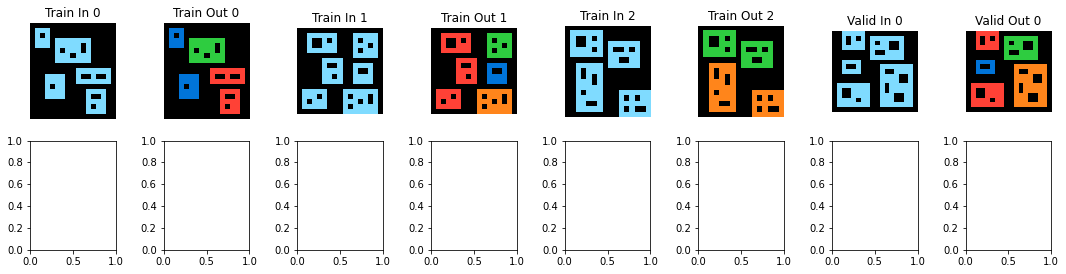

In [19]:
taskname = '37d3e8b2' #'ae58858e'
plot_task(taskname, path = evaluation_path) #training_path #evaluation_path)#, max_train=2)

plt.show() 

# submission

In [20]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())


,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...


In [21]:
path=test_path
test_tasks = set([s.split('_')[0] for s in submission.index.tolist()])

for i, t in enumerate(test_tasks):
    
    if i%25 == 0:
        print(f'{i} it done')
    try:
        preds = predTask(t, path = path)
        for p in preds:
            #print(preds.get(p))
            submission.loc[p, 'output'] = preds.get(p)
    except:
        None#print(f'Error in {t}')

print('Done!')

0 it done
Predicting 0a2355a6_0 ...

Predicted 0a2355a6

Predicted 0a2355a6
25 it done
Predicting 37d3e8b2_0 ...

Predicted 37d3e8b2
50 it done
Predicting 1da012fc_0 ...

Predicted 1da012fc
75 it done
Done!


In [22]:
display(submission.head())

submission.to_csv('submission.csv')

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...
